In [2]:
import pandas as pd
import re
import nltk
import json
import itertools
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
from itertools import *
from click import style
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import os
import json_lines
#import sbeval
import sklearn

from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

# Load ABBA corpus

In [62]:
abba_qb = pd.read_excel('../data/ABBA/abba_queerness_annotations.xlsx')
abba_qb

,Column2,Column1,ID,Argument,Sentence,newSent,Biased Tuple,Biased Sentence,Biased Comment
0,0,0,4340,"""so remember this: since god condemns sinfulne...","""here's the thing: if a christian chooses to b...","""Here's the thing: if a Christian chooses to b...","('immoral', 'gay')",0.0,0.0
1,1,1,15987,"nazi germany, pol pot, mao, mussolini, stalin,...",those who are against homosexual marriage must...,Those who are against homosexual marriage must...,"('immoral', 'homosexual')",0.0,0.0
2,2,2,15988,""" in fact they were creating a only white race...",those who are against homosexual marriage must...,Those who are against homosexual marriage must...,"('immoral', 'homosexual')",0.0,0.0
3,3,3,16562,this debate is on the protestant christian vie...,i am not arguing that the sexual orientation o...,I am not arguing that the sexual orientation o...,"('sin', 'homosexual')",1.0,1.0
4,4,4,16562,this debate is on the protestant christian vie...,i am not arguing that the sexual orientation o...,I am not arguing that the sexual orientation o...,"('emotional', 'homosexual')",1.0,1.0
...,...,...,...,...,...,...,...,...,...
882,887,887,507377,"when i hear a person say, ""being gay is a choi...",this assumption that if you think people have ...,This assumption that if you think people have ...,"('mental disorder', 'homosexual')",0.0,0.0
883,891,891,452476,no rules or structure for this debate. just de...,straight gay bisexual asexual intersex + bisex...,Straight Gay Bisexual Asexual Inte...,"('asexual', 'intersex')",0.0,0.0
884,890,890,452476,no rules or structure for this debate. just de...,straight gay bisexual asexual intersex + bisex...,Straight Gay Bisexual Asexual Inte...,"('asexual', 'intersex')",0.0,0.0
885,889,889,331360,"nothing 'happened' to free speech. ""amendment ...",lesbian gay bisexual transexual questioning in...,Lesbian Gay Bisexual Transexual Questioning In...,"('asexual', 'intersex')",0.0,0.0


In [64]:
abba_rb = pd.read_excel('../data/ABBA/abba_religious_annotations.xlsx')
abba_rb

,Column3,Column2,Column1,ID,Argument,Sentence,newSent,Biased Tuple,Biased Sentence,Biased Comment
0,0,0,0,1275,"we know that trump is a racist, a misogynist, ...","compared his ""sacrifices"" as a businessman wit...","Compared his ""sacrifices"" as a businessman wit...","('war', 'muslim')",0.0,0.0
1,1,1,1,2023,i don't call people insane for researching / t...,i don't call people insane for researching / t...,I don't call people insane for researching 9/1...,"('extremist', 'islamic')",1.0,1.0
2,2,2,2,2056,i will be arguing that / must have been assist...,()terrorist hani hanjour was not capable of fl...,(2)Terrorist Hani Hanjour was not capable of f...,"('terrorist', 'islamic')",1.0,1.0
3,3,3,3,2107,definitions conspiracy : a secret plan made by...,definitions conspiracy : a secret plan made by...,Definitions Conspiracy : a secret plan made by...,"('terrorist', 'islamic')",0.0,0.0
4,4,4,4,2111,there is a devastating lack of evidence to sup...,there is a devastating lack of evidence to sup...,There is a devastating lack of evidence to sup...,"('radical', 'muslims')",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1826,1826,1874,1874,505201,canada has % of the worlds water and has .% of...,and if that does not start a war than the tens...,and if that does not start a war than the tens...,"('war', 'muslims')",0.0,0.0
1827,1827,1875,1875,506120,. we don't need another for years if not more ...,this has led to the rise of new and dangerous ...,This has led to the rise of new and dangerous ...,"('terrorist', 'islamic')",0.0,0.0
1828,1828,1876,1876,506120,. we don't need another for years if not more ...,this has led to the rise of new and dangerous ...,This has led to the rise of new and dangerous ...,"('dangerous', 'islamic')",0.0,0.0
1829,1829,1877,1877,507373,"before i give my opinion, i want to remain you...","if u see muslim who lazy, get drunk, they're n...","if u see muslim who lazy, get drunk, they're n...","('lazy', 'muslim')",0.0,0.0


In [23]:
with open("../data/debateorg/debateorg.json", "r") as d:
    debates_dict = json.load(d)
with open("../data/debateorg/users.json", "r") as u:
      users_dict = json.load(u)
        
def extract_data(debates_data: dict, users_data: dict) -> pd.DataFrame:
    """Extract and combines debates and user data into a single dataframe. Return the dataframe.
    Currently, only the birthday, education, gender and political orientation are extracted and
    returned as user-defining features.
    Arguments:
    debates_data -- Dictionary containing the debates data.
    users_data -- Dictionary containing the users and their properties.
    """
    extracted_data = []
    properties_of_interest = ["birthday", "ethnicity", "gender", "political_ideology", "education", 
                              "interested", "income", "looking", "party", "relationship", "win_ratio", 
                              "religious_ideology", "number_of_all_debates", "big_issues_dict"]

    for key, debate in tqdm(debates_data.items()):
        # Sometimes, the users of the debate didn't exist anymore at the time
        # the data was collected.
        try:
            category = debate["category"]
        except KeyError:
            category = None
            
        try:
            title = debate["title"]
        except KeyError:
            title = None
        
        try:
            date = debate["start_date"]
        except KeyError:
            date = None
        
        try:
            user1 = users_data[debate["participant_1_name"]]
        except KeyError:
            user1 = None

        try:
            user2 = users_data[debate["participant_2_name"]]
        except KeyError:
            user2 = None

        # If both users do not exist, skip this debate
        if not user1 and not user2:
            logging.debug("Both users are absent from debate data. Skipping.")
            continue

        # For each round in this debate...
        for debate_round in debate["rounds"]:
            # For each argument in this round...
            for argument in debate_round:
                arguing_user = (
                    user1 if argument["side"] == debate["participant_1_position"] else user2)
                
                arguing_user_name = (
                    debate["participant_1_name"] if argument["side"] == debate["participant_1_position"] else debate["participant_2_name"])

                # Skip this argument if arguing user does not exist in the dta
                if not arguing_user:
                    continue
                    
                # Filtering for votes
                votes = []
                for vote in debate['votes']:
                    votes.append(vote['votes_map'][arguing_user_name])

                # Filtering for relevant properties
                properties = {
                    key: value
                    for key, value in arguing_user.items() if key in properties_of_interest}

                # Save the text and find the political ideology of the user.
                extracted_data.append({
                    "argument": argument["text"],
                    "title": title,
                    "category": category,
                    "date": date,
                    **properties,
                    "votes": votes})

    return pd.DataFrame(columns=["argument", "title", "category", "date", *properties_of_interest, "votes"], data=extracted_data)

df_debates = extract_data(debates_dict, users_dict)

df_debates = df_debates.reset_index()
df_debates = df_debates.rename(columns={"index": "ID"})

100%|██████████████████████████████████████████████████████████████████████████| 78376/78376 [00:11<00:00, 6686.02it/s]


# Queerness Bias

## Distribution of biased sentences

In [17]:
abba_qb_per_sentence = abba_qb[['Biased Sentence']].dropna()
len(abba_qb_per_sentence)

860

Text(0.5, 1.0, 'Actually biased Sentences')

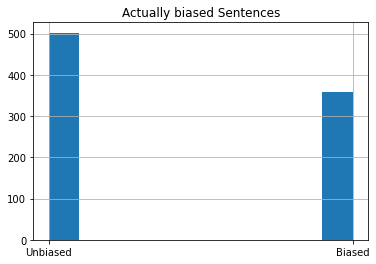

In [18]:
abba_qb_per_sentence['Biased'] = np.where(abba_qb_per_sentence['Biased Sentence']== 1.0, 'Biased', 'Unbiased')
abba_qb_per_sentence['Biased'].hist()
plt.title('Actually biased Sentences')

In [12]:
abba_qb_per_sentence['Biased'].value_counts()

Unbiased    502
Biased      358
Name: Biased, dtype: int64

## Distribution of biased comments

In [20]:
abba_qb_per_comments = abba_qb[['ID', 'Biased Comment']].dropna()
abba_qb_per_comments = abba_qb_per_comments.groupby(by=['ID']).mean().reset_index()
len(abba_qb_per_comments)

600

Text(0.5, 1.0, 'Actually biased Comments')

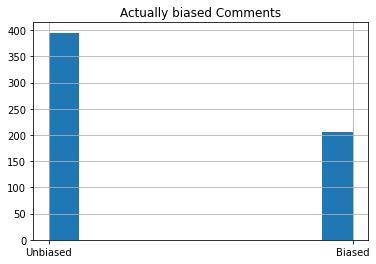

In [21]:
abba_qb_per_comments['Biased'] = np.where(abba_qb_per_comments['Biased Comment']== 1.0, 'Biased', 'Unbiased')
abba_qb_per_comments['Biased'].hist()
plt.title('Actually biased Comments')

In [22]:
abba_qb_per_comments['Biased'].value_counts()

Unbiased    395
Biased      205
Name: Biased, dtype: int64

## Merge user data

In [48]:
def calculateUserPercentage(row, total, attribute):
    return (row[attribute] / total) * 100    

In [35]:
merged_qb = pd.merge(df_debates, abba_qb, how="inner",  on="ID")
merged_qb = merged_qb.drop(columns = ['Column1', 'votes', 'Argument', 'Sentence', 'birthday', 'argument'])

In [53]:
merged_qb_biased = merged_qb[merged_qb['Biased Comment'] == 1.0]

### Political Ideology

In [52]:
merged_qb_biased_ideology = merged_qb_biased['political_ideology'].value_counts().reset_index()
total_ideology = merged_qb_biased_ideology['political_ideology'].sum()
merged_qb_biased_ideology['percentage'] = merged_qb_biased_ideology.apply(lambda row: calculateUserPercentage(row, total_ideology, 'political_ideology'), axis = 1)
merged_qb_biased_ideology

,index,political_ideology,percentage
0,Not Saying,166,53.896104
1,Conservative,68,22.077922
2,Libertarian,27,8.766234
3,Socialist,18,5.844156
4,Moderate,11,3.571429
5,Other,7,2.272727
6,Liberal,6,1.948052
7,Communist,3,0.974026
8,Progressive,1,0.324675
9,Undecided,1,0.324675


### Ethnicity

In [59]:
merged_qb_biased_ethnicity = merged_qb_biased['ethnicity'].value_counts().reset_index()
total_ethnicity = merged_qb_biased_ethnicity['ethnicity'].sum()
merged_qb_biased_ethnicity['percentage'] = merged_qb_biased_ethnicity.apply(lambda row: calculateUserPercentage(row, total_ethnicity, 'ethnicity'), axis = 1)
merged_qb_biased_ethnicity

,index,ethnicity,percentage
0,Not Saying,162,52.597403
1,White,124,40.259740
2,Asian,6,1.948052
3,Black,4,1.298701
4,Other,4,1.298701
5,Native American,3,0.974026
6,Latino,3,0.974026
7,Middle Eastern,2,0.649351


### Gender

In [60]:
merged_qb_biased_gender = merged_qb_biased['gender'].value_counts().reset_index()
total_gender= merged_qb_biased_gender['gender'].sum()
merged_qb_biased_gender['percentage'] = merged_qb_biased_gender.apply(lambda row: calculateUserPercentage(row, total_gender, 'gender'), axis = 1)
merged_qb_biased_gender

,index,gender,percentage
0,Prefer not to say,144,46.753247
1,Male,140,45.454545
2,Female,24,7.792208


# Religious Bias

## Distribution of biased sentences

In [65]:
abba_rb_per_sentence = abba_rb[['Biased Sentence']].dropna()
len(abba_rb_per_sentence)

1821

Text(0.5, 1.0, 'Actually biased Sentences')

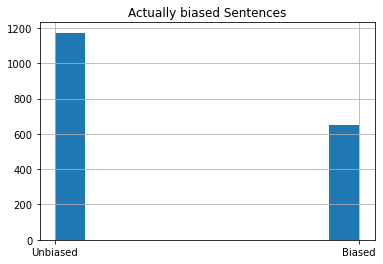

In [66]:
abba_rb_per_sentence['Biased'] = np.where(abba_rb_per_sentence['Biased Sentence']== 1.0, 'Biased', 'Unbiased')
abba_rb_per_sentence['Biased'].hist()
plt.title('Actually biased Sentences')

In [67]:
abba_rb_per_sentence['Biased'].value_counts()

Unbiased    1173
Biased       648
Name: Biased, dtype: int64

## Distribution of biased comments

In [68]:
abba_rb_per_comments = abba_rb[['ID', 'Biased Comment']].dropna()
abba_rb_per_comments = abba_rb_per_comments.groupby(by=['ID']).mean().reset_index()
len(abba_rb_per_comments)

1084

Text(0.5, 1.0, 'Actually biased Comments')

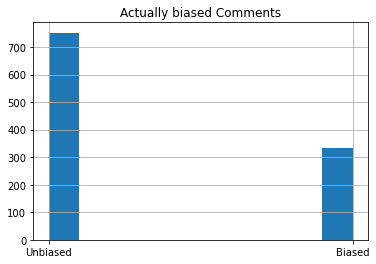

In [69]:
abba_rb_per_comments['Biased'] = np.where(abba_rb_per_comments['Biased Comment']== 1.0, 'Biased', 'Unbiased')
abba_rb_per_comments['Biased'].hist()
plt.title('Actually biased Comments')

In [70]:
abba_rb_per_comments['Biased'].value_counts()

Unbiased    752
Biased      332
Name: Biased, dtype: int64

## Merge user data

In [71]:
merged_rb = pd.merge(df_debates, abba_rb, how="inner",  on="ID")
merged_rb = merged_rb.drop(columns = ['Column1', 'votes', 'Argument', 'Sentence', 'birthday', 'argument'])

In [72]:
merged_rb_biased = merged_rb[merged_rb['Biased Comment'] == 1.0]

### Political Ideology

In [74]:
merged_rb_biased_ideology = merged_rb_biased['political_ideology'].value_counts().reset_index()
total_ideology = merged_rb_biased_ideology['political_ideology'].sum()
merged_rb_biased_ideology['percentage'] = merged_rb_biased_ideology.apply(lambda row: calculateUserPercentage(row, total_ideology, 'political_ideology'), axis = 1)
merged_rb_biased_ideology

,index,political_ideology,percentage
0,Not Saying,276,45.847176
1,Conservative,142,23.588040
2,Moderate,43,7.142857
3,Libertarian,41,6.810631
4,Other,25,4.152824
5,Progressive,20,3.322259
6,Anarchist,19,3.156146
7,Liberal,17,2.823920
8,Socialist,9,1.495017
9,Undecided,6,0.996678


### Ethnicity

In [75]:
merged_rb_biased_ethnicity = merged_rb_biased['ethnicity'].value_counts().reset_index()
total_ethnicity = merged_rb_biased_ethnicity['ethnicity'].sum()
merged_rb_biased_ethnicity['percentage'] = merged_rb_biased_ethnicity.apply(lambda row: calculateUserPercentage(row, total_ethnicity, 'ethnicity'), axis = 1)
merged_rb_biased_ethnicity

,index,ethnicity,percentage
0,White,274,45.514950
1,Not Saying,207,34.385382
2,Other,33,5.481728
3,Asian,30,4.983389
4,Native American,18,2.990033
5,East Indian,17,2.823920
6,Black,10,1.661130
7,Middle Eastern,10,1.661130
8,Latino,3,0.498339


### Gender

In [76]:
merged_rb_biased_gender = merged_rb_biased['gender'].value_counts().reset_index()
total_gender= merged_rb_biased_gender['gender'].sum()
merged_rb_biased_gender['percentage'] = merged_rb_biased_gender.apply(lambda row: calculateUserPercentage(row, total_gender, 'gender'), axis = 1)
merged_rb_biased_gender

,index,gender,percentage
0,Prefer not to say,335,55.647841
1,Male,233,38.704319
2,Female,31,5.149502
3,Transgender Male,3,0.498339
